In [82]:
import random
from copy import deepcopy
from itertools import product
from pathlib import Path

import pandas as pd 
import numpy as np
import glob
from tqdm.notebook import tqdm
import cv2
import os
from sklearn.model_selection import train_test_split
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

import albumentations as A
from albumentations.pytorch import ToTensorV2
from imgaug import augmenters as iaa

from PIL import Image
from PIL.ExifTags import TAGS

import matplotlib.pyplot as plt
from IPython.display import clear_output

from transformers import (
    ViTForImageClassification, ViTFeatureExtractor, 
    LevitForImageClassification, LevitFeatureExtractor, 
    AutoFeatureExtractor, SwinForImageClassification,
)
from sklearn.model_selection import KFold
from torch.cuda.amp import GradScaler, autocast

%matplotlib inline

# google/vit-base-patch16-224 facebook/levit-128S microsoft/swin-tiny-patch4-window7-224 facebook/deit-tiny-patch16-224 
model_name = "microsoft/swin-tiny-patch4-window7-224" 

device = "cuda"
ACCUM_BATCH_SIZE = 256
BATCH_SIZE = 128
IMG_SIZE = 10496
TRAIN_IMG_SIZE = 224
IS_CNN = True
SEED = 42

TRAIN_FOLDER = "train"

scaler = GradScaler()

def set_seed(seed: int = 1234, precision: int = 10) -> None:
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.set_printoptions(precision=precision)

set_seed(SEED)

sigmoid = torch.nn.Sigmoid()  

In [83]:
class TestData(Dataset):
    def __init__(self, images_paths, feature_extractor=None, transform=None):
        self.feature_extractor = feature_extractor
        self.images_paths = images_paths
        self.transform = transform

    def __getitem__(self, idx):
        image = cv2.imread(str(self.images_paths[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        if self.feature_extractor is not None:
            image = self.feature_extractor(images=image, return_tensors="pt")
        else:
            image = self.transform(image)

        return int(str(self.images_paths[idx].name).split(".")[0]), image
        
    def __len__(self):
        return len(self.images_paths)


In [84]:
def _compute_metric(
    data_true_batch, data_pred_batch, w = 10496, h = 10496
):
    result_metric = 0
    for data_true, data_pred in zip(data_true_batch, data_pred_batch):
        x_center_true = (data_true[0] + data_true[2]) / 2
        y_center_true = (data_true[1] + data_true[3]) / 2
        x_center_pred = (data_pred[0] + data_pred[2]) / 2
        y_center_pred = (data_pred[1] + data_pred[3]) / 2


        x_metr = abs(x_center_true - x_center_pred)
        y_metr = abs(y_center_true - y_center_pred)
        angle_metr = abs(data_true[4] - data_pred[4])

        metr = 1 - (
            0.7 * 0.5 * (x_metr + y_metr) + 
            0.3 * min(angle_metr, abs(angle_metr - 360))
        )
        result_metric += metr
    return result_metric / (len(data_true_batch) + 1)

In [85]:
class TorchLoss(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
    
    def forward(self, y_pred, y_true):
        # input shape (batch_size, 5)
        batch_size = y_pred.shape[0]

        x_center_true = (y_true[..., 0] + y_true[..., 2]) / 2
        y_center_true = (y_true[..., 1] + y_true[..., 3]) / 2
        x_center_pred = (y_pred[..., 0] + y_pred[..., 2]) / 2
        y_center_pred = (y_pred[..., 1] + y_pred[..., 3]) / 2

        x_metr = torch.abs(x_center_true - x_center_pred)
        y_metr = torch.abs(y_center_true - y_center_pred)
        angle_metr = torch.abs(y_true[..., 4] - y_pred[..., 4])

        metric = 1 - (
            0.7 * 0.5 * (x_metr + y_metr) + 
            0.3 * torch.min(angle_metr, torch.abs(angle_metr - 360))
        )
        # return -metric.sum()

        return -(metric.sum() / (batch_size + 1))


## Датасет


In [86]:
image = Image.open("../../data/original.tiff")
exifdata = image.getexif()
tags = []
data = []
for tag_id in exifdata:
    # get the tag name, instead of human unreadable tag id
    tag = TAGS.get(tag_id, tag_id)
    data.append(exifdata.get(tag_id))
    # decode bytes 
    if isinstance(data[-1], bytes):
        data[-1] = data[-1].decode()
    tags.append(tag)
    # print(f"{tag:25}: {data}")

# print("TAGS")
# for tag in tags:
#     print(tag)
# print()

# for tag, d in zip(tags, data):
#     print(f"{tag:25}: {d}")

/home/and/miniforge3/envs/mipt-hack/lib/python3.9/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (110166016 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [87]:
print(image.size)
IMG_SIZE = image.size[0]

(10496, 10496)


In [88]:
from math import sin, cos

json_dir = f"../../data/{TRAIN_FOLDER}/json/"


data_df = pd.DataFrame({'id': [], "left_top_x": [], 'left_top_y': [], "right_bottom_x": [], 'right_bottom_y': [], 'angle': []})

json_true = []
rows = []
for _, _, files in os.walk(json_dir):
  for x in files:
    if x.endswith(".json"):
      data = json.load(open(json_dir + x))
      new_row = {
        'id':x.split(".")[0]+".png", 
        'left_top_x': data["left_top"][0], 
        'left_top_y': data["left_top"][1], 
        'right_bottom_x': data["right_bottom"][0], 
        "right_bottom_y": data["right_bottom"][1], 
        "x_center": (data["left_top"][0] + data["right_bottom"][0]) / 2,
        "y_center": (data["left_top"][1] + data["right_bottom"][1]) / 2,
        'angle': data["angle"]
    }
      rows.append(new_row)

data_df = pd.DataFrame(rows)

In [89]:
data_df.head(5)

,id,left_top_x,left_top_y,right_bottom_x,right_bottom_y,x_center,y_center,angle
0,796.png,1323,2706,2564,3451,1943.5,3078.5,346
1,319.png,2180,1805,1055,2716,1617.5,2260.5,96
2,928.png,7682,8425,7933,9852,7807.5,9138.5,35
3,1058.png,2899,9854,4298,9479,3598.5,9666.5,300
4,344.png,4302,7987,5663,8482,4982.5,8234.5,335


In [90]:
data_df.describe()

,left_top_x,left_top_y,right_bottom_x,right_bottom_y,x_center,y_center,angle
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,5666.133750,5687.818750,5693.117500,5687.990000,5679.625625,5687.904375,183.107500
std,2386.511565,2532.777585,2443.211258,2560.715173,2360.269448,2494.552756,105.093884
min,1028.000000,955.000000,941.000000,877.000000,1552.500000,1540.500000,0.000000
25%,3743.750000,3495.000000,3669.250000,3476.500000,3720.000000,3479.250000,90.750000
50%,5573.000000,5554.000000,5665.000000,5604.500000,5572.000000,5585.000000,183.500000
75%,7623.000000,7926.500000,7693.000000,7921.250000,7610.500000,7919.375000,273.000000
max,10614.000000,10642.000000,10688.000000,10648.000000,9964.500000,9977.500000,359.000000


In [91]:
data_df.to_csv(f"../../data/{TRAIN_FOLDER}.csv", index=False)

In [92]:
import math

class RandomRotate(A.Rotate):
    def __init__(
        self,
        center_coords,
        limit=90,
        interpolation=cv2.INTER_LINEAR,
        border_mode=cv2.BORDER_REFLECT_101,
        value=None,
        mask_value=None,
        method="largest_box",
        crop_border=False,
        always_apply=False,
        p=0.5,
    ):
        super().__init__(
            limit, interpolation, border_mode, value, mask_value, method, crop_border, always_apply, p
        )
        self.center_coords = center_coords

        if method not in ["largest_box", "ellipse"]:
            raise ValueError(f"Rotation method {self.method} is not valid.")

    def apply_to_keypoint(
        self, keypoint, angle=0, x_min=None, x_max=None, y_min=None, y_max=None, cols=IMG_SIZE, rows=IMG_SIZE, **params
    ):
        matrix = cv2.getRotationMatrix2D(self.center_coords, angle, 1.0)
        x, y, a, s = keypoint[:4]
        x, y = cv2.transform(np.array([[[x, y]]]), matrix).squeeze()
        
        return x, y, a + math.radians(angle), s


In [93]:
# задаем преобразование изображения.

cloud_transform = iaa.Sequential([
        iaa.Clouds(seed=SEED),
    ])


# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(TRAIN_IMG_SIZE),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                           std=[0.229, 0.224, 0.225]),
# ])

# valid_transform = transforms.Compose([
#     transforms.RandomResizedCrop(TRAIN_IMG_SIZE),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                           std=[0.229, 0.224, 0.225]),
# ])


train_transform = A.Compose([
    # RandomRotate(limit=360, p=0.8),
    # A.CenterCrop(height=224, width=224),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2()
], keypoint_params=A.KeypointParams(format='xya', angle_in_degrees=True, remove_invisible=False, check_each_transform=False))

valid_transform = A.Compose([
    # A.CenterCrop(height=224, width=224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
], keypoint_params=A.KeypointParams(format='xya', angle_in_degrees=True, remove_invisible=False, check_each_transform=False))


# ORIG_IMG = cv2.resize(cv2.imread("../data/original.tiff")[:, ::-1], (1024, 1024))
# ORIG_IMG = valid_transform(Image.fromarray(ORIG_IMG))
# ORIG_IMG_BATCH = torch.stack([ORIG_IMG for _ in range(BATCH_SIZE)]).to(device)

In [94]:
# class ImageDataset(Dataset):
#     def __init__(self, data_df, feature_extractor=None, transform=None, cloud_transform=None):

#         self.data_df = data_df
#         self.transform = transform
#         self.feature_extractor = feature_extractor
#         self.cloud_transform = cloud_transform

#     def __getitem__(self, idx):
#         # достаем имя изображения и ее лейбл
#         image_name, labels = self.data_df.iloc[idx]['id'], [self.data_df.iloc[idx]['left_top_x'] / IMG_SIZE, self.data_df.iloc[idx]['left_top_y'] / IMG_SIZE, self.data_df.iloc[idx]['right_bottom_x'] / IMG_SIZE, self.data_df.iloc[idx]['right_bottom_y'] / IMG_SIZE, self.data_df.iloc[idx]['angle'] / 360]

#         # читаем картинку. read the image
#         image = cv2.imread(f"../data/{TRAIN_FOLDER}/img/{image_name}")
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         # image = cv2.resize(image, (TRAIN_IMG_SIZE, TRAIN_IMG_SIZE))
        
#         if self.cloud_transform is not None and random.random() > 0.5:
#             image = self.cloud_transform(image=image)

#         image = Image.fromarray(image)

#         if self.feature_extractor is not None:
#             image = self.feature_extractor(images=image, return_tensors="pt")
#         elif self.transform:
#             image = self.transform(image)
        
        # return int(image_name.split(".")[0]), image, torch.tensor(labels).float()
    
#     def __len__(self):
#         return len(self.data_df)


class ImageDataset(Dataset):
    def __init__(self, data_df, feature_extractor=None, transform=None, cloud_transform=None, stage="valid"):
        self.data_df = data_df
        self.transform = transform
        self.feature_extractor = feature_extractor
        self.cloud_transform = cloud_transform
        self.stage = stage

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name = self.data_df.iloc[idx]['id']
        keypoints = np.array([
            [self.data_df.iloc[idx]['left_top_x'], self.data_df.iloc[idx]['left_top_y'], self.data_df.iloc[idx]['angle']],
            [self.data_df.iloc[idx]['right_bottom_x'], self.data_df.iloc[idx]['left_top_y'], self.data_df.iloc[idx]['angle']],
            [self.data_df.iloc[idx]['right_bottom_x'], self.data_df.iloc[idx]['right_bottom_y'], self.data_df.iloc[idx]['angle']],
            [self.data_df.iloc[idx]['left_top_x'], self.data_df.iloc[idx]['right_bottom_y'], self.data_df.iloc[idx]['angle']],
        ])

        # читаем картинку. read the image
        image = cv2.imread(f"../../data/{TRAIN_FOLDER}/img/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.resize(image, (TRAIN_IMG_SIZE, TRAIN_IMG_SIZE))
        
        # преобразуем, если нужно. transform it, if necessary
        if self.cloud_transform is not None and random.random() > 0.5:
            image = self.cloud_transform(image=image)

        if self.feature_extractor is not None:
            image = self.feature_extractor(images=image, return_tensors="pt")
        elif self.transform:
            if self.stage == "train":
                center_coords = (keypoints[:, 0].min() + keypoints[:, 0].max()) // 2, (keypoints[:, 1].min() + keypoints[:, 1].max()) // 2

                self.transform = A.Compose([
                    RandomRotate(center_coords=np.float32(center_coords), limit=360, p=0.9),
                    # A.CenterCrop(height=224, width=224),
                    A.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]
                    ),
                    ToTensorV2()
                ], keypoint_params=A.KeypointParams(format='xya', angle_in_degrees=True, remove_invisible=False, check_each_transform=False))

            # transformed = self.transform(image=image, keypoints=keypoints)
            # image, keypoints = transformed["image"], transformed["keypoints"]
            image = self.transform(Image.fromarray(image))


        labels = [
            keypoints[0][0] / IMG_SIZE, 
            keypoints[0][1] / IMG_SIZE, 
            keypoints[2][0] / IMG_SIZE, 
            keypoints[2][1] / IMG_SIZE, 
            keypoints[0][2] / 360
        ]
        return int(image_name.split(".")[0]), image, torch.tensor(labels).float()
    
    def __len__(self):
        return len(self.data_df)

In [95]:
# читаем датасет
data_df = pd.read_csv(f"../../data/{TRAIN_FOLDER}.csv")

In [96]:
from os import listdir

print("Обучающей выборки " ,len(listdir(f"../../data/{TRAIN_FOLDER}/img")))
print("Тестовой выборки " ,len(listdir("../../data/test")))

Обучающей выборки  800
Тестовой выборки  400


In [97]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.05, random_state=42)

In [98]:
train_df.shape, valid_df.shape

((760, 8), (40, 8))

In [99]:
full_dataset = ImageDataset(
    data_df, 
    transform=train_transform, 
    cloud_transform=cloud_transform, 
    feature_extractor=None if IS_CNN else AutoFeatureExtractor.from_pretrained(model_name),
    stage="train"
)
train_dataset = ImageDataset(
    train_df, 
    transform=train_transform, 
    cloud_transform=cloud_transform, 
    feature_extractor=None if IS_CNN else AutoFeatureExtractor.from_pretrained(model_name),
    stage="train"
)
valid_dataset = ImageDataset(
    valid_df, 
    transform=train_transform, 
    # cloud_transform=cloud_transform, 
    feature_extractor=None if IS_CNN else AutoFeatureExtractor.from_pretrained(model_name),
    stage="valid"
    )

In [100]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=4, 
                                           drop_last=True,
                                           )

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=BATCH_SIZE,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=4)

## Вспомогательные функции

In [30]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [22]:
def train(
    model, criterion, optimizer, scheduler, train_dataloader, test_dataloader, NUM_EPOCH=15, accum_batch_size=ACCUM_BATCH_SIZE
):
    global best_model
    train_loss_log = []
    val_loss_log = []
    train_metrics = []
    val_metrics = []
    best_loss = np.inf

    optimizer.zero_grad(set_to_none=True) 
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        
        for i, (_, imgs, labels) in enumerate(train_dataloader):

            if not IS_CNN:
                for j in imgs:
                    imgs[j] = imgs[j][:, 0].to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

            else:
                imgs = imgs.to(device)
                labels = labels.to(device)

            accum_iter = accum_batch_size / len(labels)

            with autocast():
                # y_pred = model(imgs, ORIG_IMG_BATCH[:len(labels)])
                y_pred = model(imgs)
                
                loss = criterion(y_pred, labels)


            # loss.backward()
            scaler.scale(loss).backward()
            
            train_loss_log.append(loss.data.item())
            train_metrics.append(-loss.data.item())
            # train_loss_log.append((loss.data / y_pred.size(0)).item())
            
            # train_metrics.append(_compute_metric(labels.detach().cpu().tolist(), y_pred.detach().cpu().tolist()))

            if ((i + 1) % accum_iter == 0) or (i + BATCH_SIZE >= len(train_dataloader)):
            # if (i + 1) % 2 == 0 or (i + 1) == len(train_dataloader):
                # optimizer.step()
                scaler.step(optimizer)   
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
                
        # train_loss_log.append((loss.data / y_pred.size(0)).item())

        val_loss = 0.
        val_size = 0
                
        model.eval()
        
        with torch.no_grad():
            for _, imgs, labels in test_dataloader:
                
                if not IS_CNN:
                    for i in imgs:
                        imgs[i] = imgs[i][:, 0].to(device, non_blocking=True)
                    labels = labels.to(device, non_blocking=True)

                else:
                    imgs = imgs.to(device)
                    labels = labels.to(device)

                with autocast():
                    # pred = model(imgs, ORIG_IMG_BATCH[:len(labels)])
                    pred = model(imgs)

                    loss = criterion(pred, labels)
                
                val_loss += loss.item()
                val_size += 1 # pred.size(0)
     
        val_loss_log.append(val_loss / val_size)
        val_metrics.append(-(val_loss / val_size))
        # val_metrics.append(_compute_metric(labels.cpu().tolist(), pred.cpu().tolist()))

        if scheduler is not None:
            scheduler.step(val_loss_log[-1])
            
        cur_lr = optimizer.param_groups[0]['lr']

        if val_loss_log[-1] < best_loss:
            best_loss = val_loss_log[-1]
            best_model = deepcopy(model)
            torch.save(best_model.state_dict(), "best.pth")

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')

        print("LR:", cur_lr)
        print('Train score:', train_metrics[-1])
        print('Last Val score:', val_metrics[-1])
        print('Best Val score:', max(val_metrics))

    return best_model, max(val_metrics)

In [23]:
def crossvalid(dataset=None, k_folds=5, n_epochs=15):

    networks = []

    kfold = KFold(n_splits=k_folds, shuffle=True)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        print(f'FOLD: {fold}')

        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        valid_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

        # Define data loaders for training and testing data in this fold
        train_loader = torch.utils.data.DataLoader(
            dataset, 
            batch_size=BATCH_SIZE, 
            sampler=train_subsampler,
            drop_last=True,
            pin_memory=True,
        )
        valid_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=BATCH_SIZE, 
            sampler=valid_subsampler
        )

        # Init the neural network

        # network = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        # network.fc = nn.Linear(network.fc.in_features, 5)

        # network = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        # network.classifier[1] = nn.Linear(network.classifier[1].in_features, 5)

        # model_name = "facebook/levit-128S"
        # network = LevitForImageClassification.from_pretrained(model_name)
        # network.classifier.linear = nn.Linear(
        #     network.classifier.linear.in_features, 5
        # )

        network = CNN()


        network.to(device)

        # Initialize optimizer
        # criterion = torch.nn.L1Loss()
        criterion = TorchLoss()
        optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 'min', factor=0.1, patience=4, verbose=True
        )
        

        network, val_score = train(
            network, criterion, optimizer, scheduler, train_loader, valid_loader, n_epochs, accum_batch_size=256
        )

        networks.append((val_score, network))

        print('Val score:', val_score)
        
    return networks

## Модель

In [20]:
class CNN(nn.Module):
    def __init__(self, name="res50") -> None:
        super().__init__()

        if name == "res18":
            self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
            self.model.fc = nn.Linear(self.model.fc.in_features, 5)
        elif name == "res34":
            self.model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
            self.model.fc = nn.Linear(self.model.fc.in_features, 5)
        elif name == "res50":
            self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
            self.model.fc = nn.Linear(self.model.fc.in_features, 5)
        elif name == "regnet_y_3_2gf":
            self.model = models.regnet_y_3_2gf(
                weights=models.RegNet_Y_3_2GF_Weights.IMAGENET1K_V2
            )
            self.model.fc = nn.Linear(self.model.fc.in_features, 5)
        elif name == "regnet_y_8gf":
            self.model = models.regnet_y_8gf(
                weights=models.RegNet_Y_8GF_Weights.IMAGENET1K_V2
            )
            self.model.fc = nn.Linear(self.model.fc.in_features, 5)
        elif name == "regnet_y_16gf":
            self.model = models.regnet_y_16gf(
                weights=models.RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1
            )
            self.model.fc = nn.Linear(self.model.fc.in_features, 5)
        elif name == "effb0":
            self.model = models.efficientnet_b0(
                weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
            )
            self.model.classifier[1] = nn.Linear(
                self.model.classifier[1].in_features, 5
            )
        elif name == "effb1":
            self.model = models.efficientnet_b1(
                weights=models.EfficientNet_B1_Weights.IMAGENET1K_V2
            )
            self.model.classifier[1] = nn.Linear(
                self.model.classifier[1].in_features, 5
            )
        elif name == "effb3":
            self.model = models.efficientnet_b3(
                weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1
            )
            self.model.classifier[1] = nn.Linear(
                self.model.classifier[1].in_features, 5
            )
        elif name == "effb4":
            self.model = models.efficientnet_b4(
                weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1
            )
            self.model.classifier[1] = nn.Linear(
                self.model.classifier[1].in_features, 5
            )
        elif name == "effb5":
            self.model = models.efficientnet_b5(
                weights=models.EfficientNet_B5_Weights.IMAGENET1K_V1
            )
            self.model.classifier[1] = nn.Linear(
                self.model.classifier[1].in_features, 5
            )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        return x


class TrNN(nn.Module):
    def __init__(self, name="vit") -> None:
        super().__init__()
        # google/vit-base-patch16-224 facebook/levit-128S microsoft/swin-tiny-patch4-window7-224 facebook/deit-tiny-patch16-224 

        if name == "vit":
            self.model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
            self.model.classifier = nn.Linear(
                self.model.classifier.in_features, 5
            )
        elif name == "levit":
            self.model = LevitForImageClassification.from_pretrained("facebook/levit-128S")
            self.model.classifier.linear = nn.Linear(
                self.model.classifier.linear.in_features, 5
            )
        elif name == "swin":
            self.model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
            self.model.classifier = nn.Linear(
                self.model.classifier.in_features, 5
            )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(**x).logits
        x = self.sigmoid(x)
        return x


class TwoHeadsCNN(nn.Module):
    def __init__(self, name="res50") -> None:
        super().__init__()

        if name == "res50":
            self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
            in_features = self.model.fc.in_features
        elif "eff" in name:
            in_features = self.model.classifier[1].in_features
            if name == "effb1":
                self.model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V2)
            elif name == "effb3":
                self.model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
            elif name == "effb4":
                self.model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)
            elif name == "effb5":
                self.model = models.efficientnet_b5(weights=models.EfficientNet_B5_Weights.IMAGENET1K_V1)

        self.model = torch.nn.Sequential(*(list(self.model.children())[:-1]))
        self.fc = nn.Linear(in_features * 2, 5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_img, original_img):
        x1 = self.model(input_img)
        x2 = self.model(original_img)
        x = torch.cat((x1.view(x1.size(0), -1), x2.view(x2.size(0), -1)), dim=1)
        # x = torch.cat((x1, x2), dim=1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


## CrossVal

In [25]:
# networks = crossvalid(full_dataset, k_folds=5, n_epochs=40)

In [26]:
# preds = [[] for _ in range(5)]
# gt = []

# for score, net in networks:
#     net.eval()

# for model_num, (score, model) in enumerate(networks):
#     with torch.no_grad():
#         for _, imgs, labels in valid_loader:
            
#             if IS_CNN:
#                 imgs = imgs.to(device)
#                 labels = labels.to(device)
#                 pred = model(imgs)
#             else:
#                 for i in imgs:
#                     imgs[i] = imgs[i][:, 0].to(device, non_blocking=True)
#                 labels = labels.to(device, non_blocking=True)
#                 pred = model(imgs)

#             preds[model_num].extend(pred.cpu().tolist())
#             if model_num == 0:
#                 gt.extend(labels.cpu().tolist())

# agg_prediction = np.array(preds).mean(axis=0)
# print(agg_prediction.shape)
# _compute_metric(gt, agg_prediction)

In [27]:
# 0.8157453097074193

In [28]:
# for i, (score, model) in enumerate(networks):
#     torch.save(model.state_dict(), f"./res50_torchloss_clouds_crossval/model_fold{i}_{score:.2f}.pth")

In [29]:
# preds = [[] for _ in range(5)]
# gt = []

# for score, net in networks:
#     net.eval()

# test_transform = transforms.Compose([
#     transforms.Resize(TRAIN_IMG_SIZE),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                         std=[0.229, 0.224, 0.225]),
# ])
# images_paths = sorted(list(Path("../data/test").iterdir()), key = lambda p: int(p.name[:-4]))
# test_dataset = TestData(images_paths, None, test_transform)

# img_ids = []
# for model_num, (score, model) in enumerate(networks):
#     with torch.no_grad():
#         for img_id, imgs in test_dataset:
#             imgs = imgs.unsqueeze(0)
#             if model_num == 0:
#                 img_ids.append(img_id)

#             if IS_CNN:
#                 imgs = imgs.to(device)
#                 labels = labels.to(device)
#                 pred = model(imgs)
#             else:
#                 for i in imgs:
#                     imgs[i] = imgs[i][:, 0].to(device, non_blocking=True)
#                 labels = labels.to(device, non_blocking=True)
#                 pred = model(imgs)

#             preds[model_num].extend(pred.cpu().tolist())
#             if model_num == 0:
#                 gt.extend(labels.cpu().tolist())

# agg_prediction = np.array(preds).mean(axis=0)

In [30]:
# submit_folder = Path("../data/crossval_submit/")
# for img_id, pred in tqdm(zip(img_ids, agg_prediction), total=len(img_ids)):
#     res = {
#         "left_top": [pred[0] * IMG_SIZE, pred[1] * IMG_SIZE],
#         "right_top": [pred[2] * IMG_SIZE, pred[1] * IMG_SIZE],
#         "left_bottom": [pred[0] * IMG_SIZE, pred[3] * IMG_SIZE],
#         "right_bottom": [pred[2] * IMG_SIZE, pred[3] * IMG_SIZE],
#         "angle": pred[4] * 360
#     }
    
#     with open(submit_folder / f"{img_id}.json", "w") as f:
#         json.dump(res, f)

## Basic train

In [31]:
torch.cuda.empty_cache()

In [32]:
# Подргружаем модель
model = CNN("res50") if IS_CNN else TrNN()
# model = TwoHeadsCNN("res50") 

# model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
# model.fc = nn.Linear(model.fc.in_features, 5)

# model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
# model.classifier[1] = nn.Linear(model.classifier[1].in_features, 5)

# model = LevitForImageClassification.from_pretrained(model_name)
# # model.classifier = nn.Linear(
# #     model.classifier.in_features, 5
# # )
# model.classifier.linear = nn.Linear(
#     model.classifier.linear.in_features, 5
# )


model = model.to(device)
# criterion = torch.nn.L1Loss()
criterion = TorchLoss()
sigmoid = torch.nn.Sigmoid()

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=4, verbose=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=0.0001, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=5, epochs=70)


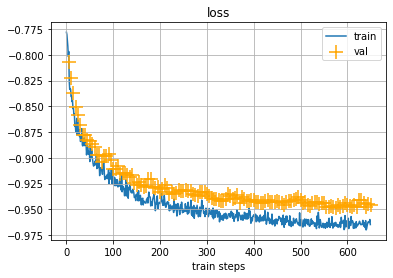

LR: 0.0004019583657941649
Train score: 0.9647833704948425
Last Val score: 0.9456698000431061
Best Val score: 0.9486280977725983


In [37]:
best_model = None
best_model, val_score = train(
    model, 
    criterion, 
    optimizer, 
    scheduler, 
    train_loader, 
    valid_loader,
    130
)

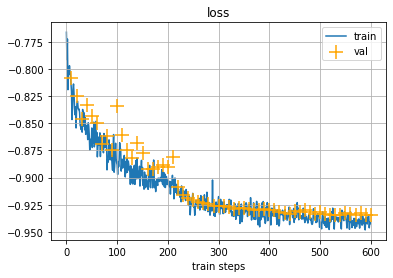

LR: 1e-05
Train score: 0.942428469657898
Last Val score: 0.9347390731175741
Best Val score: 0.9347390731175741


In [36]:
best_model = None
best_model, val_score = train(
    model, 
    criterion, 
    optimizer, 
    scheduler, 
    train_loader, 
    valid_loader,
    60
)

## Посчитаем метрику

In [38]:
model.eval()
best_model.eval()
print()

In [34]:
model.load_state_dict(torch.load("/home/and/projects/hacks/ai-areal-photo/experiments/sota_train/run_res50/best.pth")["model"])
model.eval()

ModuleNotFoundError: No module named 'config'

In [39]:
preds = []
gt = []
with torch.no_grad():
    for _, imgs, labels in valid_loader:
        
        if IS_CNN:
            imgs = imgs.to(device)
            labels = labels.to(device)

            pred = model(imgs)
        else:
            for i in imgs:
                imgs[i] = imgs[i][:, 0].to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            pred = model(imgs)

        preds.extend(pred.cpu().tolist())
        gt.extend(labels.cpu().tolist())
_compute_metric(gt, preds)

0.9616184013390987

In [40]:
preds = []
gt = []
with torch.no_grad():
    for _, imgs, labels in valid_loader:
        
        if IS_CNN:
            imgs = imgs.to(device)
            labels = labels.to(device)

            pred = best_model(imgs)
        else:
            for i in imgs:
                imgs[i] = imgs[i][:, 0].to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            pred = best_model(imgs)

        preds.extend(pred.cpu().tolist())
        gt.extend(labels.cpu().tolist())
_compute_metric(gt, preds)

0.9634149164127715

In [30]:
# levit123s - 0.8037
# levit192 - 0.8003


# Regression Aggregation

In [101]:
import torch.nn as nn
from torchvision import models


class CNN(nn.Module):
    def __init__(self, name="res50") -> None:
        super().__init__()

        if name == "res18":
            self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
            self.model.fc = nn.Linear(self.model.fc.in_features, 5)
        elif name == "res34":
            self.model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
            self.model.fc = nn.Linear(self.model.fc.in_features, 5)
        elif name == "res50":
            self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
            self.model.fc = nn.Linear(self.model.fc.in_features, 5)
        elif name == "regnet_y_3_2gf":
            self.model = models.regnet_y_3_2gf(
                weights=models.RegNet_Y_3_2GF_Weights.IMAGENET1K_V2
            )
            self.model.fc = nn.Linear(self.model.fc.in_features, 5)
        elif name == "regnet_y_8gf":
            self.model = models.regnet_y_8gf(
                weights=models.RegNet_Y_8GF_Weights.IMAGENET1K_V2
            )
            self.model.fc = nn.Linear(self.model.fc.in_features, 5)
        elif name == "regnet_y_16gf":
            self.model = models.regnet_y_16gf(
                weights=models.RegNet_Y_16GF_Weights.IMAGENET1K_SWAG_E2E_V1
            )
            self.model.fc = nn.Linear(self.model.fc.in_features, 5)
        elif name == "effb0":
            self.model = models.efficientnet_b0(
                weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
            )
            self.model.classifier[1] = nn.Linear(
                self.model.classifier[1].in_features, 5
            )
        elif name == "effb1":
            self.model = models.efficientnet_b1(
                weights=models.EfficientNet_B1_Weights.IMAGENET1K_V2
            )
            self.model.classifier[1] = nn.Linear(
                self.model.classifier[1].in_features, 5
            )
        elif name == "effb3":
            self.model = models.efficientnet_b3(
                weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1
            )
            self.model.classifier[1] = nn.Linear(
                self.model.classifier[1].in_features, 5
            )
        elif name == "effb4":
            self.model = models.efficientnet_b4(
                weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1
            )
            self.model.classifier[1] = nn.Linear(
                self.model.classifier[1].in_features, 5
            )
        elif name == "effb5":
            self.model = models.efficientnet_b5(
                weights=models.EfficientNet_B5_Weights.IMAGENET1K_V1
            )
            self.model.classifier[1] = nn.Linear(
                self.model.classifier[1].in_features, 5
            )
        elif name == "swin_t":
            self.model = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)
            self.model.head = nn.Linear(self.model.head.in_features, 5)

        elif name == "convnext_s":
            self.model = models.convnext_small(
                weights=models.ConvNeXt_Small_Weights.IMAGENET1K_V1
            )
            self.model.classifier[2] = nn.Linear(
                self.model.classifier[2].in_features, 5
            )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        return x


In [109]:
from catboost import CatBoostRegressor

class TestData(Dataset):
    def __init__(self, images_paths, feature_extractor=None, transform=None):
        self.feature_extractor = feature_extractor
        self.images_paths = images_paths
        self.transform = transform

    def __getitem__(self, idx):
        image = cv2.imread(str(self.images_paths[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        if self.feature_extractor is not None:
            image = self.feature_extractor(images=image, return_tensors="pt")
        else:
            image = self.transform(image)

        return int(str(self.images_paths[idx].name).split(".")[0]), image
        
    def __len__(self):
        return len(self.images_paths)

models_weights = [
    "best_res50_clouds_0.91.pth", 
    "best_effb3_clouds_0.92.pth", 
    "best_effb1_clouds_0.91.pth",
    # "best_levit128S_clouds_0.82.pth", 
    # "best_vit_clouds_0.83.pth", 
    # "best_swin_clouds_0.83.pth"
]
img_sizes = [
    224, 
    224, 
    224, 
    224,
    # 224, 
    # 224
]

In [118]:
cv_models = []

model = CNN("regnet_y_8gf")
weights = torch.load(
    "/home/and/projects/hacks/ai-areal-photo/experiments/sota_train/run_regnet_y_8gf/best.pth"
)["model"]
model.load_state_dict(weights)
# model = torch.nn.Sequential(*(list(list(model.children())[0].children())[:-1]))
cv_models.append(model)

model = CNN("regnet_y_8gf")
weights = torch.load(
    "/home/and/projects/hacks/ai-areal-photo/experiments/sota_train/run_regnet_y_8gf_clouds_v2/regnet_y_8gf_best_weights.pth"
)
model.load_state_dict(weights)
# model = torch.nn.Sequential(*(list(list(model.children())[0].children())[:-1]))
cv_models.append(model)

# model = CNN("regnet_y_8gf")
# weights = torch.load(
#     "/home/and/projects/hacks/ai-areal-photo/experiments/sota_train/run_regnet_y_8gf_clouds_autoaug/best.pth"
# )["model"]
# model.load_state_dict(weights)
# # model = torch.nn.Sequential(*(list(list(model.children())[0].children())[:-1]))
# cv_models.append(model)

model = CNN("regnet_y_3_2gf")
weights = torch.load(
    "/home/and/projects/hacks/ai-areal-photo/experiments/sota_train/run_regnet_y_3_2gf/best.pth"
)["model"]
model.load_state_dict(weights)
# model = torch.nn.Sequential(*(list(list(model.children())[0].children())[:-1]))
cv_models.append(model)

for model in cv_models:
    model.to(device)
    model.eval()
    

In [119]:
import presets
from config import Config
# from datasets import ImageDataset
from torchvision.transforms.functional import InterpolationMode

cfg = Config()
interpolation = InterpolationMode(cfg.interpolation)


 # generate train_df
def generate_preds_df(model_num, pred_df, model, dataset):
    rows = []
    for img_id, img, labels in tqdm(dataset):
        labels = labels.tolist()
        with torch.no_grad():
            img = img.unsqueeze(0).to(device, non_blocking=True)
                    
            pred = model(img)
            # print(pred.shape)
            pred = pred.squeeze(0).cpu().flatten()
            row = {
                'id': img_id, 
                **{str(i): p.item() for i, p in enumerate(pred)},
                # "left_top_x": pred[0], 
                # 'left_top_y': pred[1], 
                # "right_bottom_x": pred[2], 
                # 'right_bottom_y': pred[3], 
                # 'angle': pred[4],
                "gt_left_top_x": labels[0], 
                'gt_left_top_y': labels[1], 
                "gt_right_bottom_x": labels[2], 
                'gt_right_bottom_y': labels[3], 
                'gt_angle': labels[4],
            }
            rows.append(row)
    data_df = pd.DataFrame(rows)
    if model_num == 0:
        pred_df = data_df
    else:
        data_df = data_df.drop(["gt_left_top_x", "gt_left_top_y", "gt_right_bottom_x", "gt_right_bottom_y", "gt_angle"], axis=1)
        pred_df = pred_df.merge(
            data_df, 
            on="id", 
            suffixes=("", f"_{model_num}")
        )

    return pred_df


pred_train_df = None
pred_valid_df = None

for model_num, (model, img_size) in enumerate(zip(cv_models[:], img_sizes)):

    test_transform = presets.PresetEval(
        crop_size=cfg.val_crop_size,
        resize_size=cfg.val_resize_size,
        interpolation=interpolation,
    )

    train_dataset = ImageDataset(
        train_df,
        feature_extractor=None,
        transform=test_transform,
        cloud_transform=None,
        stage="valid"
    )
    valid_dataset = ImageDataset(valid_df, feature_extractor=None, transform=test_transform, cloud_transform=None, stage="valid")

    pred_train_df = generate_preds_df(model_num, pred_train_df, model, train_dataset)
    pred_valid_df = generate_preds_df(model_num, pred_valid_df, model, valid_dataset)

    print(f"Model {model_num} predictions generated!")


  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Model 0 predictions generated!


  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Model 1 predictions generated!


  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Model 2 predictions generated!


In [112]:
# pred_train_df.to_csv(f"../data/agg_pred/{TRAIN_FOLDER}.csv", index=False)
# pred_valid_df.to_csv("../data/agg_pred/valid.csv", index=False)

In [113]:
# pred_train_df = pd.read_csv(f"../data/agg_pred/{TRAIN_FOLDER}.csv")
# pred_valid_df = pd.read_csv("../data/agg_pred/valid.csv")

In [120]:
pred_train_df.head()

,id,0,1,2,3,4,gt_left_top_x,gt_left_top_y,gt_right_bottom_x,gt_right_bottom_y,...,0_1,1_1,2_1,3_1,4_1,0_2,1_2,2_2,3_2,4_2
0,985,0.468807,0.309138,0.937968,0.106497,0.593582,0.711414,0.278868,0.697027,0.141578,...,0.411403,0.421899,0.967832,0.009231,0.604143,0.468343,0.371821,0.934366,0.068633,0.629204
1,664,0.709716,0.293989,0.973762,0.087421,0.713968,0.797828,0.237805,0.866902,0.118236,...,0.676560,0.372771,0.988938,0.013084,0.714243,0.704484,0.323949,0.965629,0.084925,0.752569
2,750,0.017330,0.105826,0.375847,0.424110,0.053152,0.162633,0.199219,0.229611,0.319931,...,0.016227,0.505026,0.399785,0.028419,0.066137,0.014074,0.433426,0.385662,0.109766,0.036017
3,441,0.065264,0.964522,0.879069,0.820515,0.633954,0.509146,0.990663,0.466559,0.859470,...,0.085199,0.997052,0.904948,0.835940,0.584384,0.137581,0.851226,0.868024,0.953664,0.628111
4,598,0.060304,0.216824,0.492366,0.576876,0.423685,0.346989,0.406059,0.213700,0.370332,...,0.030661,0.720495,0.527145,0.064002,0.413503,0.062540,0.580849,0.524231,0.197178,0.435299


In [144]:
# # Train AGG Regressor

class Regressor(nn.Module):
  def __init__(self, in_features=25):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(in_features, 512),
      nn.ELU(),
      nn.Linear(512, 256),
      nn.ELU(),
      nn.Linear(256, 64),
      nn.ELU(),
      nn.Linear(64, 32),
      nn.ELU(),
      nn.Linear(32, 5),
      nn.Sigmoid()
    )

  def forward(self, x):
    return self.layers(x)


pred_train_data = pred_train_df.drop(["id", "gt_left_top_x", "gt_left_top_y", "gt_right_bottom_x", "gt_right_bottom_y", "gt_angle"], axis=1)
pred_valid_data = pred_valid_df.drop(["id", "gt_left_top_x", "gt_left_top_y", "gt_right_bottom_x", "gt_right_bottom_y", "gt_angle"], axis=1)

gt_train = pred_train_df[["gt_left_top_x", "gt_left_top_y", "gt_right_bottom_x", "gt_right_bottom_y", "gt_angle"]]
gt_valid = pred_valid_df[["gt_left_top_x", "gt_left_top_y", "gt_right_bottom_x", "gt_right_bottom_y", "gt_angle"]]


# ### CAT
# regressor = CatBoostRegressor(
#     loss_function='MultiRMSE',
#     iterations=2500,
# )

# regressor.fit(pred_train_data, gt_train, eval_set=(pred_valid_data, gt_valid), verbose=1)
# # print("Saving model")
# # regressor.save_model("regressor.cbm")


### NN
set_seed(SEED)
regressor = Regressor(pred_train_data.shape[-1])
regressor.to(device)
criterion = TorchLoss()
optimizer = torch.optim.Adam(regressor.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5500, eta_min=1e-6)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=100, epochs=3500)

train_metrics, val_metrics = [], []
best_score = 0
for epoch in tqdm(range(5500)):
    regressor.train()
    train_pred = []
    data = torch.from_numpy(pred_train_data.values).float().to(device)
    labels = torch.from_numpy(gt_train.values).float().to(device)
    pred = regressor(data)
    loss = criterion(pred, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_pred.extend(pred.cpu().tolist())


    regressor.eval()
    val_pred = []
    with torch.no_grad():
        data = torch.from_numpy(pred_valid_data.values).float().to(device)
        pred = regressor(data)        
        val_pred.extend(pred.cpu().tolist())

    train_metrics.append(_compute_metric(gt_train.values, train_pred))
    val_metrics.append(_compute_metric(gt_valid.values, val_pred))

    if val_metrics[-1] > best_score:
        best_regressor = deepcopy(regressor)
        best_score = val_metrics[-1]

    # scheduler.step(-val_metrics[-1])

    print('Last Train score:', train_metrics[-1], ' Best Val score:', max(val_metrics))


  0%|          | 0/5500 [00:00<?, ?it/s]

Last Train score: 0.7792556343084923  Best Val score: 0.7877065816394437
Last Train score: 0.78900807940471  Best Val score: 0.7878225022063748
Last Train score: 0.7950764974005254  Best Val score: 0.7900075076284204
Last Train score: 0.8008469607119308  Best Val score: 0.796573991355736
Last Train score: 0.8081394360958797  Best Val score: 0.8065646814046112
Last Train score: 0.8171918032577077  Best Val score: 0.8180795264952795
Last Train score: 0.8273675909249969  Best Val score: 0.8296399480958536
Last Train score: 0.8386383901621889  Best Val score: 0.8418635105487049
Last Train score: 0.8515663804259972  Best Val score: 0.8533005975277688
Last Train score: 0.8650302929092688  Best Val score: 0.8648745872171186
Last Train score: 0.8792513485720109  Best Val score: 0.879894852193027
Last Train score: 0.8949941780208887  Best Val score: 0.8913523327014066
Last Train score: 0.9089538812692398  Best Val score: 0.9010881313190953
Last Train score: 0.9193161460265034  Best Val score: 0

In [122]:
# 0.8960
# 8998
# 0.9698 (0.9702) - фичи моделей res50 + effb0 + effb1
# 0.9656 - ответы моделей с sigmoid + sigmoid
# 0.9655 (0.9673 adam) - ответы моделей + sigmoid

# 9845
# 9861

#### 
# 0.05
# 0.9672

In [145]:
# Validation

# val_prediction = regressor.predict(pred_valid_data)
# _compute_metric(gt_valid.values, val_prediction)

best_regressor.eval()
with torch.no_grad():
    val_prediction = best_regressor(torch.from_numpy(pred_valid_data.values).float().to(device)).cpu().tolist()
_compute_metric(gt_valid.values, val_prediction)

0.9671675277828444

In [149]:
torch.save(best_regressor.state_dict(), "agg_regressor9671.pth")

# Inference

In [125]:
def generate_preds_df_test(model_num, pred_df, model, dataset):
    rows = []
    for img_id, img in tqdm(dataset):
        with torch.no_grad():
            img = img.to(device, non_blocking=True)
            
            pred = model(img.unsqueeze(0)).squeeze(0).cpu()

            row = {
                'id': img_id, 
                # "left_top_x": pred[0], 
                # 'left_top_y': pred[1], 
                # "right_bottom_x": pred[2], 
                # 'right_bottom_y': pred[3], 
                # 'angle': pred[4],
                **{str(i): p.item() for i, p in enumerate(pred)},
            }
            rows.append(row)
    data_df = pd.DataFrame(rows)
    if model_num == 0:
        pred_df = data_df
    else:
        pred_df = pred_df.merge(
            data_df, 
            on="id", 
            suffixes=("", f"_{model_num}")
        )

    return pred_df

In [126]:
images_paths = sorted(list(Path("../../data/test").iterdir()), key = lambda p: int(p.name[:-4]))

pred_test_df = None
for model_num, (model, img_size) in enumerate(zip(cv_models[:], img_sizes)):

    test_transform = presets.PresetEval(
        crop_size=cfg.val_crop_size,
        resize_size=cfg.val_resize_size,
        interpolation=interpolation,
    )

    test_dataset = TestData(images_paths, None, test_transform)

    pred_test_df = generate_preds_df_test(model_num, pred_test_df, model, test_dataset)

    print(f"Model {model_num} predictions generated!")

  0%|          | 0/400 [00:00<?, ?it/s]

Model 0 predictions generated!


  0%|          | 0/400 [00:00<?, ?it/s]

Model 1 predictions generated!


  0%|          | 0/400 [00:00<?, ?it/s]

Model 2 predictions generated!


In [131]:
pred_test_df.head()

,id,0,1,2,3,4,0_1,1_1,2_1,3_1,4_1,0_2,1_2,2_2,3_2,4_2
0,3,0.500500,0.810973,0.969948,0.509553,0.782437,0.459642,0.955428,0.988364,0.345690,0.775439,0.497066,0.482436,0.943368,0.852211,0.797244
1,4,0.879626,0.247538,0.974377,0.456550,0.414283,0.820645,0.667921,0.998856,0.032949,0.380379,0.843325,0.548381,0.976358,0.148426,0.364341
2,5,0.058725,0.455575,0.518808,0.653309,0.402115,0.034230,0.863877,0.553619,0.197154,0.421632,0.071191,0.537435,0.493953,0.581681,0.396432
3,10,0.233097,0.878190,0.821543,0.576520,0.665325,0.221221,0.974365,0.840629,0.449459,0.700676,0.199014,0.540024,0.867158,0.922012,0.706526
4,11,0.814392,0.296344,0.981166,0.340949,0.896403,0.775829,0.613684,0.997368,0.026010,0.940376,0.760917,0.549642,0.979941,0.113414,0.911014


In [146]:
ids = pred_test_df.id
# prediction = regressor.predict(pred_test_df.drop("id", axis=1))
with torch.no_grad():
    prediction = best_regressor(torch.from_numpy(pred_test_df.drop("id", axis=1).values).float().to(device)).cpu().tolist()

In [147]:
submit_folder = Path("../../data/agg_submit_regnets_v2/")
for img_id, pred in tqdm(zip(ids, prediction), total=len(ids)):
    res = {
        "left_top": [pred[0] * IMG_SIZE, pred[1] * IMG_SIZE],
        "right_top": [pred[2] * IMG_SIZE, pred[1] * IMG_SIZE],
        "left_bottom": [pred[0] * IMG_SIZE, pred[3] * IMG_SIZE],
        "right_bottom": [pred[2] * IMG_SIZE, pred[3] * IMG_SIZE],
        "angle": pred[4] * 360
    }
    
    with open(submit_folder / f"{img_id}.json", "w") as f:
        json.dump(res, f)

  0%|          | 0/400 [00:00<?, ?it/s]